## Business Understanding
- Goal: Predict product's rating from the dataset provided.

## Set-up Environment

In [1]:
import findspark
findspark.init()

In [2]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession

import pandas as pd
import numpy as np
import pandas_profiling as pp

import matplotlib
matplotlib.use('Qt5Agg')
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from datetime import datetime
from pyspark.sql.functions import *
from pyspark.sql import types 
from pyspark.sql.types import *
from pyspark.ml.feature import *

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StringIndexer, Tokenizer, StopWordsRemover, CountVectorizer, IDF, OneHotEncoder
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel
from pyspark.ml.classification import DecisionTreeClassifier, DecisionTreeClassificationModel
from pyspark.ml.classification import RandomForestClassifier, RandomForestClassificationModel
from pyspark.ml.classification import GBTClassifier, GBTClassificationModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator, RegressionEvaluator
from pyspark.ml import Pipeline

import warnings
warnings.filterwarnings("ignore")

In [3]:
sc = SparkContext()

In [4]:
spark = SparkSession.builder.appName('rating').getOrCreate()

## Data loading

In [5]:
df = pd.read_excel('womens-ecommerce-clothing-reviews\Womens_Clothing_E_Commerce_Reviews.xlsx', index_col = 0, sheet_name = 'Reviews')

In [6]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23481 entries, 0 to 23480
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23481 non-null  int64 
 1   Age                      23481 non-null  int64 
 2   Title                    19671 non-null  object
 3   Review Text              22636 non-null  object
 4   Rating                   23481 non-null  int64 
 5   Recommended IND          23481 non-null  int64 
 6   Positive Feedback Count  23481 non-null  int64 
 7   Division Name            23467 non-null  object
 8   Department Name          23467 non-null  object
 9   Class Name               23467 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [8]:
df.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating',
       'Recommended IND', 'Positive Feedback Count', 'Division Name',
       'Department Name', 'Class Name'],
      dtype='object')

## Data Understading

#### Feature Understanding
- Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
- Age: Positive Integer variable of the reviewers age.
- Title: String variable for the title of the review.
- Review Text: String variable for the review body.
- Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
- Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
- Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
- Division Name: Categorical name of the product high level division.
- Department Name: Categorical name of the product department name.
- Class Name: Categorical name of the product class name.

In [9]:
schema = StructType([
    StructField("ClothingID", IntegerType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Title", StringType(), True),
    StructField("Review Text", StringType(), True),
    StructField("Rating", IntegerType(), True),
    StructField("Recommended IND", IntegerType(), True),
    StructField("Positive Feedback Count", IntegerType(), True),
    StructField("Division Name", StringType(), True),
    StructField("Department Name", StringType(), True),
    StructField("Class Name", StringType(), True)])
rating = spark.createDataFrame(df, schema)

In [10]:
rating.printSchema()

root
 |-- ClothingID: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Title: string (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Recommended IND: integer (nullable = true)
 |-- Positive Feedback Count: integer (nullable = true)
 |-- Division Name: string (nullable = true)
 |-- Department Name: string (nullable = true)
 |-- Class Name: string (nullable = true)



In [11]:
print('Total row & column of the dataset:', rating.count(), 'rows and', len(rating.columns), 'columns')

Total row & column of the dataset: 23481 rows and 10 columns


In [12]:
for row in rating.take(3):
    print(row)
    print('\n')

Row(ClothingID=767, Age=33, Title='NaN', Review Text='Absolutely wonderful - silky and sexy and comfortable', Rating=4, Recommended IND=1, Positive Feedback Count=0, Division Name='Initmates', Department Name='Intimate', Class Name='Intimates')


Row(ClothingID=1080, Age=34, Title='NaN', Review Text='Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.', Rating=5, Recommended IND=1, Positive Feedback Count=4, Division Name='General', Department Name='Dresses', Class Name='Dresses')


Row(ClothingID=1077, Age=60, Title='Some major design flaws', Review Text='I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in

## Data preparation

I will rename the column in order to easily call the column name.

In [13]:
rating = rating.withColumnRenamed('Review Text', 'Reviewtext')
rating = rating.withColumnRenamed('Recommended IND', 'Recommended')
rating = rating.withColumnRenamed('Positive Feedback Count', 'Positive_Feedback')
rating = rating.withColumnRenamed('Division Name', 'Divisionname')
rating = rating.withColumnRenamed('Department Name', 'Departmentname')
rating = rating.withColumnRenamed('Class Name', 'Classname')

In [14]:
rating.columns

['ClothingID',
 'Age',
 'Title',
 'Reviewtext',
 'Rating',
 'Recommended',
 'Positive_Feedback',
 'Divisionname',
 'Departmentname',
 'Classname']

### Data cleaning

In [15]:
#nan checking
rating.select([count(when(isnan(c), c)).alias(c) for c in rating.columns]).toPandas().T

,0
ClothingID,0
Age,0
Title,3810
Reviewtext,845
Rating,0
Recommended,0
Positive_Feedback,0
Divisionname,14
Departmentname,14
Classname,14


- There is a large amount of Nan value in "Title" (3810 rows) and "Review Text" (845 rows) column. Which accoungt for 16% and 3.6%.
- The rest have nan value but not much (0.06%): "Division Name", "Department Name", "Class Name".

In [16]:
rating = rating.filter(~isnan(col('Title')))
rating = rating.filter(~isnan(col('Review Text')))
rating = rating.filter(~isnan(col('Division Name')))

In [17]:
#null checking
rating.select([count(when(col(c).isNull(), c)).alias(c) for c in rating.columns]).toPandas().T

,0
ClothingID,0
Age,0
Title,0
Reviewtext,0
Rating,0
Recommended,0
Positive_Feedback,0
Divisionname,0
Departmentname,0
Classname,0


There is no null value in the data

In [18]:
#Duplicate value
print('Total of duplicate row:', rating.count() - rating.distinct().count())

Total of duplicate row: 0


- There is no duplicate row after drop the nan row.
(before drop nan, the duplicate row is 21 rows)

In [19]:
rating.toPandas().profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Single Variable Analysis

In [20]:
nums = [col[0] for col in rating.dtypes if col[1] != 'string']
objs = ['Divisionname', 'Departmentname', 'Classname']

The "Title" and "Review Text" Are text data type so it can not be in the Single Analysis task, we will be discover in transformation task for text data type.

========== ClothingID ==========
+-------+------------------+
|summary|        ClothingID|
+-------+------------------+
|  count|             19657|
|   mean| 921.2860558579641|
| stddev|200.24593046369904|
|    min|                 1|
|    25%|               861|
|    50%|               936|
|    75%|              1078|
|    max|              1205|
+-------+------------------+

+--------------------+--------------------+
|skewness(ClothingID)|kurtosis(ClothingID)|
+--------------------+--------------------+
| -2.1022645539387437|   5.346130932351992|
+--------------------+--------------------+



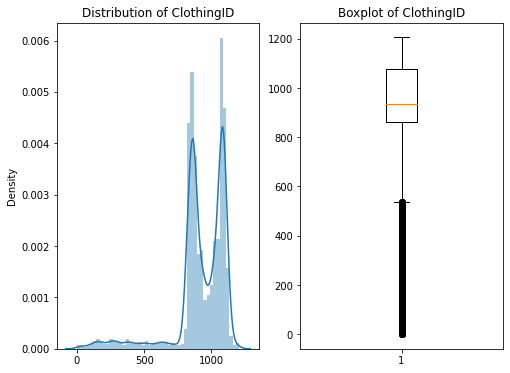

========== Age ==========
+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|             19657|
|   mean|43.260619626596124|
| stddev| 12.25781636963354|
|    min|                18|
|    25%|                34|
|    50%|                41|
|    75%|                52|
|    max|                99|
+-------+------------------+

+------------------+-------------------+
|     skewness(Age)|      kurtosis(Age)|
+------------------+-------------------+
|0.5155399253332676|-0.1396447307497537|
+------------------+-------------------+



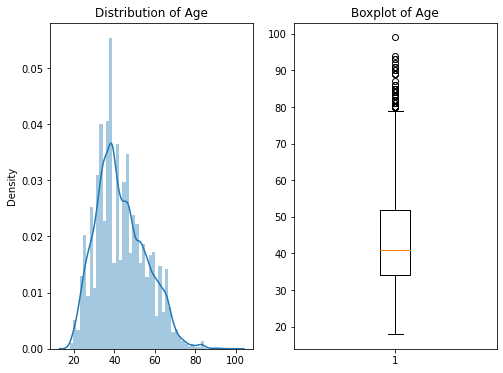

========== Rating ==========
+-------+------------------+
|summary|            Rating|
+-------+------------------+
|  count|             19657|
|   mean| 4.183446100625731|
| stddev|1.1119767696496712|
|    min|                 1|
|    25%|                 4|
|    50%|                 5|
|    75%|                 5|
|    max|                 5|
+-------+------------------+

+------------------+-----------------+
|  skewness(Rating)| kurtosis(Rating)|
+------------------+-----------------+
|-1.280466353817569|0.707620975913295|
+------------------+-----------------+



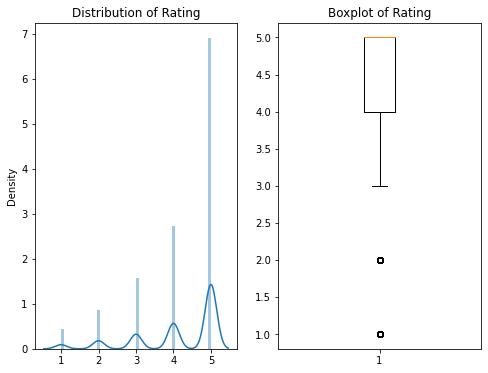

========== Recommended ==========
+-------+-------------------+
|summary|        Recommended|
+-------+-------------------+
|  count|              19657|
|   mean|   0.81828356310729|
| stddev|0.38562045893675284|
|    min|                  0|
|    25%|                  1|
|    50%|                  1|
|    75%|                  1|
|    max|                  1|
+-------+-------------------+

+---------------------+---------------------+
|skewness(Recommended)|kurtosis(Recommended)|
+---------------------+---------------------+
|  -1.6508027620119359|    0.725149759066233|
+---------------------+---------------------+



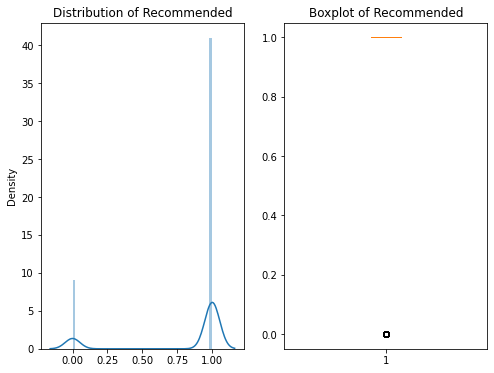

========== Positive_Feedback ==========
+-------+------------------+
|summary| Positive_Feedback|
+-------+------------------+
|  count|             19657|
|   mean|2.6518288650353563|
| stddev| 5.834245161388916|
|    min|                 0|
|    25%|                 0|
|    50%|                 1|
|    75%|                 3|
|    max|               122|
+-------+------------------+

+---------------------------+---------------------------+
|skewness(Positive_Feedback)|kurtosis(Positive_Feedback)|
+---------------------------+---------------------------+
|          6.340666147391571|          67.51643082355508|
+---------------------------+---------------------------+



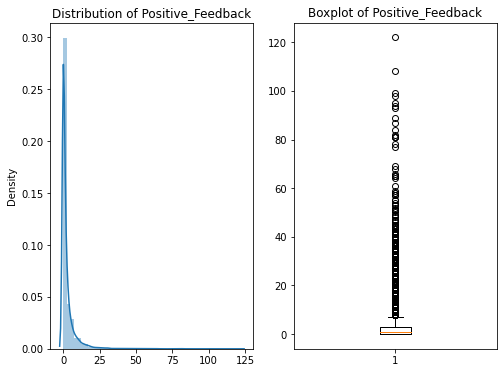

In [21]:
for cols in nums:
    print('='*10, cols, '='*10)
    rating.select(cols).summary().show()
    rating.select(skewness(cols),kurtosis(cols)).show()
    
    plt.figure(figsize = (8,6))
    plt.subplot(1,2,1)
    sns.distplot(rating.select(cols).toPandas())
    plt.title('Distribution of '+cols)
    
    plt.subplot(1,2,2)
    plt.boxplot(rating.select(cols).toPandas())
    plt.title('Boxplot of '+cols)
    plt.show()

- The result show that:
    - Most of feature have outliers: Age, Positive_Feedback, other have mot much and CothingID not count in this case.
    - Right skew feature: Age, Positive_Feedback
    - Left Skew: the rest features.

========== Divisionname ==========
+--------------+-----+
|  Divisionname|count|
+--------------+-----+
|     Initmates| 1220|
|       General|11659|
|General Petite| 6778|
+--------------+-----+



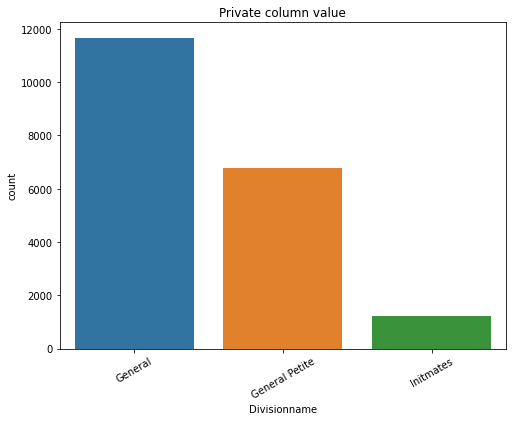

========== Departmentname ==========
+--------------+-----+
|Departmentname|count|
+--------------+-----+
|       Dresses| 5369|
|          Tops| 8710|
|       Jackets|  879|
|         Trend|  107|
|      Intimate| 1408|
|       Bottoms| 3184|
+--------------+-----+



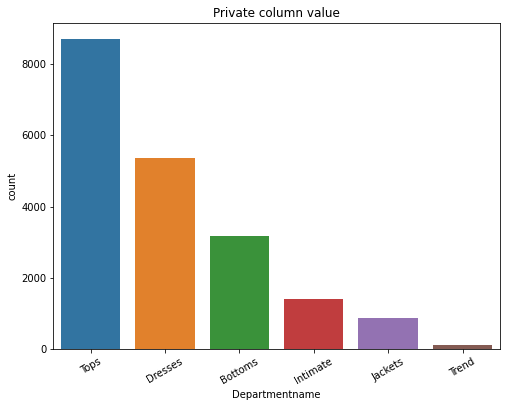

========== Classname ==========
+--------------+-----+
|     Classname|count|
+--------------+-----+
|       Dresses| 5369|
|     Outerwear|  281|
|          Swim|  293|
|       Blouses| 2587|
|         Knits| 3979|
|       Jackets|  598|
|         Trend|  107|
|        Lounge|  574|
|      Chemises|    1|
|         Pants| 1157|
|    Fine gauge|  927|
|      Layering|  115|
|        Skirts|  796|
|     Intimates|  120|
|Casual bottoms|    1|
|       Legwear|  131|
|         Sleep|  174|
|        Shorts|  260|
|      Sweaters| 1217|
|         Jeans|  970|
+--------------+-----+



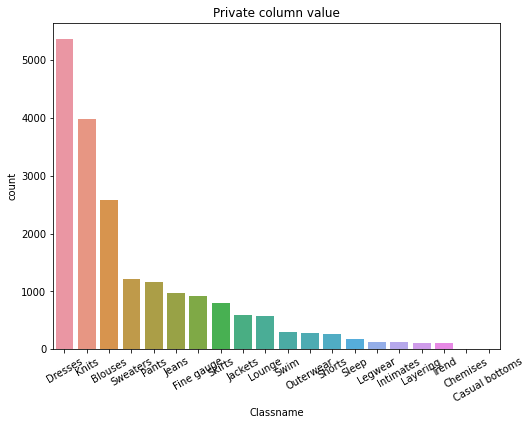

In [22]:
for cols in objs:
    print('='*10, cols, '='*10)
    rating.groupBy(cols).count().show()

    plt.figure(figsize = (8,6))
    sns.barplot(x = cols, y = 'count', data = rating.groupBy(cols).count().orderBy(desc('count')).toPandas())
    plt.title(cosl + ' value')
    plt.xticks(rotation = 30)
    plt.show()

- The categories feature result show that:
    - Most of product are located at 1 popular category of feature.
    - Divisionname have 11k products with General, while the Initiate category just ahve 1.2kk product.
    - Also with departmentname, top and dresses have been counted the most with 8k and 5k product.
    - Finally, the Classname is similar with departmentname but it showed more detail, that mean more categories. In this case, I will not use Classname because it will interupt the model's performance and time executed.

### Multivariable Analysis

#### Continuous & Continuous

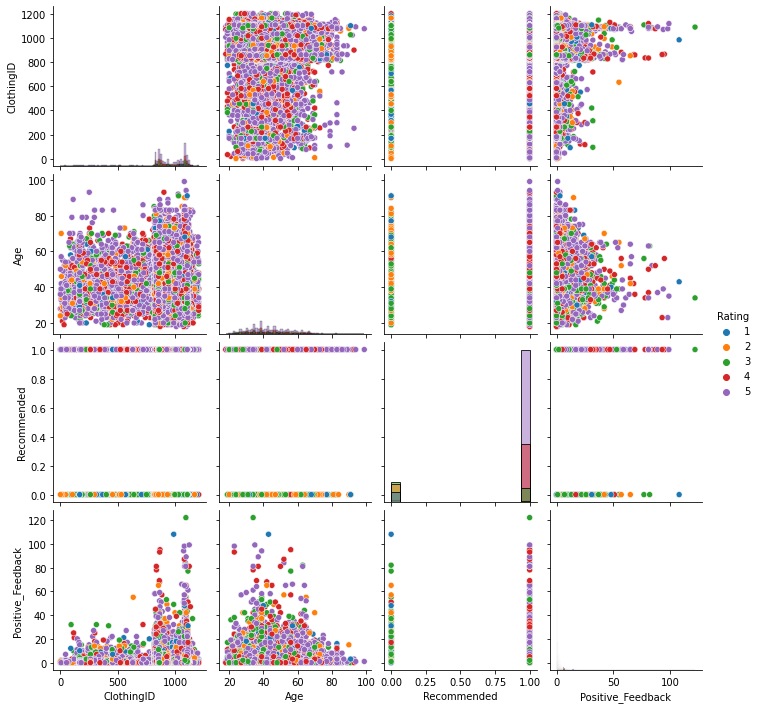

In [23]:
sns.pairplot(rating.select(nums).toPandas(), hue = 'Rating', diag_kind = 'hist', palette = 'tab10')

The output features seem does not affect each other much.

#### Continuous & Category

In [24]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [25]:
def anova(f1, f2, f3, data):
    print('-'*20, 'Anova between {}, {} and {}'.format(f1,f2,f3), '-'*20)
    model = ols('{} ~ C({}) + C({}) + C({}):C({})'.format(f1,f2,f3,f2,f3), data = ano).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    return anova_table
def tukeyhsd(f1, f2, f3, data):
    print('-'*20, 'TukeyHSD test between {}, {} and {}'.format(f1,f2,f3), '-'*20)
    print('\n')
    for name, grouped_df in data.groupby(f2):
        print('{} {}'.format(f2, name), pairwise_tukeyhsd(grouped_df[f1],
                                                         grouped_df[f3], alpha = 0.05))

In [26]:
ano = rating.select(['Age', 'Positive_Feedback', 'Recommended', 'Divisionname', 'Departmentname','Classname']).toPandas()

##### Positive_Feedback, Recommended and Divisionname

In [27]:
anova('Positive_Feedback', 'Recommended', 'Divisionname', ano)

-------------------- Anova between Positive_Feedback, Recommended and Divisionname --------------------


,sum_sq,df,F,PR(>F)
C(Recommended),2298.279971,1.0,67.797020,1.924395e-16
C(Divisionname),557.708845,2.0,8.225934,2.685449e-04
C(Recommended):C(Divisionname),1.300019,2.0,0.019175,9.810080e-01
Residual,666157.596372,19651.0,NaN,NaN


Recommended, Divisionname and Recommended:Divisionname is significant (<0.05) => Recommended and Divisionname affect Positive_Feedback

In [28]:
tukeyhsd('Positive_Feedback', 'Recommended', 'Divisionname', ano)

-------------------- TukeyHSD test between Positive_Feedback, Recommended and Divisionname --------------------


Recommended 0         Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
       General General Petite   0.0141    0.9 -0.5414 0.5696  False
       General      Initmates  -0.7691  0.281 -1.9537 0.4155  False
General Petite      Initmates  -0.7832 0.2895  -2.004 0.4376  False
-------------------------------------------------------------------
Recommended 1         Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj  lower   upper  reject
-------------------------------------------------------------------
       General General Petite   0.0233   0.9 -0.1996  0.2462  False
       General      Initmates  -0.6744 0.001 -1.1067  -0.242   True
General Petite      Initmates  -0.6976 0.0

- With Positive_Feedback, Recommended and Divisionname case, except:
    - Recommended 1 - General & Initmates, General Petile & Initmates can temporarily reject Null hypothesis.
    - The rest case have failed in reject Null hypothesis.

##### Positive_Feedback, Recommended and Departmentname

In [29]:
anova('Positive_Feedback', 'Recommended', 'Departmentname', ano)

-------------------- Anova between Positive_Feedback, Recommended and Departmentname --------------------


,sum_sq,df,F,PR(>F)
C(Recommended),2165.338906,1.0,64.060332,1.273272e-15
C(Departmentname),2594.385489,5.0,15.350687,4.290876e-15
C(Recommended):C(Departmentname),90.653380,5.0,0.536386,7.488776e-01
Residual,664031.566368,19645.0,NaN,NaN


Recommended, Departmentname and Recommended:Departmentname significant with p<0.05 => Recommended and Departmentname affect Positive_Feedback

In [30]:
tukeyhsd('Positive_Feedback', 'Recommended', 'Departmentname', ano)

-------------------- TukeyHSD test between Positive_Feedback, Recommended and Departmentname --------------------


Recommended 0   Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
 Bottoms  Dresses   0.9078 0.1311 -0.1376 1.9532  False
 Bottoms Intimate  -0.0367    0.9 -1.5831 1.5098  False
 Bottoms  Jackets   1.1974 0.4153 -0.6166 3.0115  False
 Bottoms     Tops   0.3018    0.9 -0.6829 1.2865  False
 Bottoms    Trend   1.9293 0.6718 -1.8658 5.7244  False
 Dresses Intimate  -0.9445 0.3927 -2.3485 0.4596  False
 Dresses  Jackets   0.2896    0.9 -1.4047 1.9839  False
 Dresses     Tops   -0.606 0.1816 -1.3472 0.1352  False
 Dresses    Trend   1.0215    0.9 -2.7178 4.7608  False
Intimate  Jackets   1.2341 0.5138 -0.8078  3.276  False
Intimate     Tops   0.3384    0.9  -1.021 1.6979  False
Intimate    Trend    1.966 0.6808 -1.9432 5.8751  False
 Jackets     Tops  -0.8957 0.6

- But when apply Tukey test, the result showed that there is just a few cases proved Rcommended and Departmentname affect Positive_Feedback:
    - Recomended 1: Bottom&Dresses, Dresses&Intimate, Dresses&Tops and Intimate&Tops can reject Null hypothesis temporarily.
    - The rest failed to reject Null hypothesis.

##### Age, Recommended and Divisionname

In [31]:
anova('Age', 'Recommended', 'Divisionname', ano)

-------------------- Anova between Age, Recommended and Divisionname --------------------


,sum_sq,df,F,PR(>F)
C(Recommended),3.845320e+03,1.0,25.658164,4.112567e-07
C(Divisionname),4.654851e+03,2.0,15.529911,1.822930e-07
C(Recommended):C(Divisionname),1.626725e+01,2.0,0.054272,9.471744e-01
Residual,2.945042e+06,19651.0,NaN,NaN


Recommended, Divisionname and Recommended:Divisionname is significant (<0.05) => Recommended and Divisionname affect Age

In [32]:
tukeyhsd('Age', 'Recommended', 'Divisionname', ano)

-------------------- TukeyHSD test between Age, Recommended and Divisionname --------------------


Recommended 0         Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------
       General General Petite  -0.1613    0.9 -1.1453 0.8227  False
       General      Initmates  -1.9334 0.0783 -4.0317 0.1648  False
General Petite      Initmates  -1.7721 0.1327 -3.9345 0.3903  False
-------------------------------------------------------------------
Recommended 1         Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1         group2     meandiff p-adj  lower   upper  reject
-------------------------------------------------------------------
       General General Petite  -0.0231   0.9 -0.5121   0.466  False
       General      Initmates  -2.0491 0.001 -2.9976 -1.1006   True
General Petite      Initmates   -2.026 0.001 -3.0069 -1.

Resul showed that only Recommended 1 with General&Initmates, General Petile&Initmates have temporary reject Null hypothesis.

##### Age, Recommended and Departmentname

In [33]:
anova('Age', 'Recommended', 'Departmentname', ano)

-------------------- Anova between Age, Recommended and Departmentname --------------------


,sum_sq,df,F,PR(>F)
C(Recommended),3.806418e+03,1.0,25.502344,4.457995e-07
C(Departmentname),1.706070e+04,5.0,22.860743,5.898659e-23
C(Recommended):C(Departmentname),4.874060e+02,5.0,0.653107,6.591255e-01
Residual,2.932165e+06,19645.0,NaN,NaN


Recommended, Departmentname and Recommended:Departmentname is significant (<0.05) => Recommended and Departmentname affect Age

In [34]:
tukeyhsd('Age', 'Recommended', 'Departmentname', ano)

-------------------- TukeyHSD test between Age, Recommended and Departmentname --------------------


Recommended 0   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
 Bottoms  Dresses  -0.2659    0.9 -2.1178   1.586  False
 Bottoms Intimate  -1.2453 0.7604 -3.9849  1.4943  False
 Bottoms  Jackets   0.8342    0.9 -2.3795  4.0479  False
 Bottoms     Tops   0.9762 0.5875 -0.7682  2.7206  False
 Bottoms    Trend   2.9743 0.7804 -3.7488  9.6975  False
 Dresses Intimate  -0.9794 0.8605 -3.4667  1.5079  False
 Dresses  Jackets   1.1001    0.9 -1.9014  4.1016  False
 Dresses     Tops    1.242 0.0763 -0.0711  2.5551  False
 Dresses    Trend   3.2402 0.7035 -3.3841  9.8646  False
Intimate  Jackets   2.0795 0.5624 -1.5378  5.6968  False
Intimate     Tops   2.2214 0.0902 -0.1869  4.6298  False
Intimate    Trend   4.2196 0.5057 -2.7056 11.1448  False
 Jackets     Tops   0.1419   

- Result with Tukey test showed that:
    - Recomended 1: Bottom&Dresses, Dresses&Intimate, Bottom&Tops, Dresses&Jackets, Dresses&Tops, Intimate&Jackets and Intimate&Tops can reject Null hypothesis temporarily.
    - The rest failed to reject Null hypothesis

Because the num feature contain a lot of outliers, so I will findout how much (%) the outliers accounted for.

In [35]:
def outliers_detect(f):
    Q1 = np.percentile(ratings[f], 25)
    Q3 = np.percentile(ratings[f], 75)

    upper_outlier = ratings[ratings[f] > (Q3 + 1.5*(Q3 - Q1))].shape[0]
    lower_outlier = ratings[ratings[f] < (Q1 - 1.5*(Q3 - Q1))].shape[0]
    print('Percentage of outlier in dataset:', (((upper_outlier+lower_outlier)/ratings.shape[0])*100),'%')

In [36]:
ratings = rating.toPandas()

In [37]:
outliers_detect('Age')

Percentage of outlier in dataset: 0.4629394108968815 %


In [38]:
outliers_detect('Positive_Feedback')

Percentage of outlier in dataset: 9.569110240626749 %


- The outliers of Age accounted for 0.4% of the data (quite small)
- Causion: The outliers of Positive_Feed back accounted for 9.5% of the data. So we need to delete it.
- The Recommended column also have outliers, but because it is Clothes ID which mean it is a categorical type, so that we do not have to delete it.

- May be the outliers of Positive_Feedback will contain outliers of Age column, so we will eliminate outliers based on the Positive_Feedback column

In [39]:
Q1 = np.percentile(ratings['Positive_Feedback'], 25)
Q3 = np.percentile(ratings['Positive_Feedback'], 75)

upper_outlier = ratings[ratings['Positive_Feedback'] > (Q3 + 1.5*(Q3 - Q1))].shape[0]
lower_outlier = ratings[ratings['Positive_Feedback'] < (Q1 - 1.5*(Q3 - Q1))].shape[0]

print('Total row of data before delete outliers:', ratings.shape[0])
ratings = ratings[(ratings['Positive_Feedback'] >= (Q1 - 1.5*(Q3 - Q1))) & (ratings['Positive_Feedback'] <= (Q3 + 1.5*(Q3 - Q1)))]
print('Total row of data after delete outliers:', ratings.shape[0])

Total row of data before delete outliers: 19657
Total row of data after delete outliers: 17776


### Data transformation

In [40]:
#transform the text column
ratings.columns

Index(['ClothingID', 'Age', 'Title', 'Reviewtext', 'Rating', 'Recommended',
       'Positive_Feedback', 'Divisionname', 'Departmentname', 'Classname'],
      dtype='object')

In [41]:
ratings[['Title', 'Reviewtext','Divisionname', 'Departmentname', 'Classname']]

,Title,Reviewtext,Divisionname,Departmentname,Classname
0,Some major design flaws,I had such high hopes for this dress and reall...,General,Dresses,Dresses
1,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",General Petite,Bottoms,Pants
2,Flattering shirt,This shirt is very flattering to all due to th...,General,Tops,Blouses
3,Not for the very petite,"I love tracy reese dresses, but this one is no...",General,Dresses,Dresses
4,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,General Petite,Tops,Knits
...,...,...,...,...,...
19651,What a fun piece!,So i wasn't sure about ordering this skirt bec...,General Petite,Bottoms,Skirts
19652,Great dress for many occasions,I was very happy to snag this dress at such a ...,General Petite,Dresses,Dresses
19653,Wish it was made of cotton,"It reminds me of maternity clothes. soft, stre...",General Petite,Tops,Knits
19654,"Cute, but see through","This fit well, but the top was very see throug...",General Petite,Dresses,Dresses


- Title and Reviewtext is have sentence value => stopwordremover and idf
- Divisionname, Departmentname and Classname have single string/ category string value => OneHotEncoder

- The title will display the general idea of the Reviewtext, or we can say it is the Reviewtext's sumarized. But the weakness of the title can not describe all about the user's thought. The good respond title does mean that product will receive 5* from them, user always leave the reason in the feedback so that is the key to measure their satisfaction. => use Reviewtext column instead of both.
- The three column left (Divisionname, Departmentname and Classname) have the same attribute is to show the Women clothes's categorization. But in general, the Departmentname display the clothes's category clearly so I will use it.

In [42]:
#Select feature for transform
schema = StructType([
    StructField("ClothingID", IntegerType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Review Text", StringType(), True),
    StructField("Rating", IntegerType(), True),
    StructField("Recommended IND", IntegerType(), True),
    StructField("Positive Feedback Count", IntegerType(), True),
    StructField("Department Name", StringType(), True)])

rating = spark.createDataFrame(ratings[['ClothingID', 'Age', 'Reviewtext', 'Rating', 'Recommended',
       'Positive_Feedback', 'Divisionname', 'Departmentname', 'Classname']])

In [43]:
rating.printSchema()

root
 |-- ClothingID: long (nullable = true)
 |-- Age: long (nullable = true)
 |-- Reviewtext: string (nullable = true)
 |-- Rating: long (nullable = true)
 |-- Recommended: long (nullable = true)
 |-- Positive_Feedback: long (nullable = true)
 |-- Divisionname: string (nullable = true)
 |-- Departmentname: string (nullable = true)
 |-- Classname: string (nullable = true)



In [44]:
indexer1 = StringIndexer(inputCol = 'Departmentname', outputCol = 'Department_idx')
indexer3 = StringIndexer(inputCol = 'Divisionname', outputCol = 'Division_idx')
indexer5 = StringIndexer(inputCol = 'Recommended', outputCol = 'Recommended_idx')
tokenizer = Tokenizer(inputCol = 'Reviewtext', outputCol = 'Review_token')
stopword = StopWordsRemover(inputCol = 'Review_token', outputCol = 'Review_filtered')
count_vec = CountVectorizer(inputCol = 'Review_filtered', outputCol = 'Review_count', maxDF = 0.7)
idf = IDF(inputCol = 'Review_count', outputCol = 'Review_idf')
onehot1 = OneHotEncoder(inputCol = 'Department_idx',
                                outputCol = 'Department_dummy')
onehot2 = OneHotEncoder(inputCol = 'Division_idx',
                                outputCol = 'Division_dummy')
asembler = VectorAssembler(inputCols = ['ClothingID', 'Age', 'Review_idf', 'Recommended_idx', 'Positive_Feedback',
                                        'Division_dummy', 'Department_dummy'], outputCol = 'features')

In [45]:
pipeline = Pipeline(stages = [indexer1,
                              indexer3, indexer5,
                              tokenizer, stopword, count_vec, idf, asembler])

In [46]:
data = pipeline.fit(rating).transform(rating)

data.select(['Rating', 'Rating_idx']).distinct().show()

In [47]:
data = data.select(['Rating', 'features'])

## Build regression model

In [161]:
def decisiontree_model(dataset, label):
    train_set, test_set = dataset.randomSplit([0.8, 0.2])
    #build three models
    tree = DecisionTreeClassifier(labelCol = label, featuresCol = 'features')
    
    #Fit 3 model with train dataset
    tree_model = tree.fit(train_set)
    
    #Predict with test dataset
    tree_pred = tree_model.transform(test_set)
    tree_prednlabel = tree_pred.select(['prediction', label]).withColumn(label, col(label).cast('float')).orderBy('prediction')

    #Select predoction result for evaluate the performance
    #accuracy_evaluation = MulticlassClassificationEvaluator(labelCol = 'PrivateIndex', predictionCol = 'prediction',metricName = 'accuracy')
    bi_evaluator = BinaryClassificationEvaluator(labelCol = label, rawPredictionCol = 'prediction')
    multi_evaluator = MulticlassClassificationEvaluator(labelCol = label, predictionCol = 'prediction')
    #Evaluate
    tree_acc = multi_evaluator.evaluate(tree_prednlabel, {multi_evaluator.metricName: "accuracy"})

    #save model
    tree_model.save('treemodel_rating')
    
    #Show the result
    print('Accuracy Score:')
    print('-'*80)
    print('Decision Tree accuracy: {0:2.2f}%'.format(tree_acc*100))
    
    print('\n')
    print('Confusion matrix')
    print('-'*80)
    print('Decision tree')
    tree_prednlabel.groupby(label, 'prediction').count().show()

In [162]:
def forest_model(dataset, label):
    #split dataset into train and test set
    train_set, test_set = dataset.randomSplit([0.8, 0.2])
    #build three models
    forest = RandomForestClassifier(labelCol = label, featuresCol = 'features')
    
    #Fit 3 model with train dataset
    forest_model = forest.fit(train_set)
    
    #Predict with test dataset
    forest_pred = forest_model.transform(test_set)
    
    forest_prednlabel = forest_pred.select(['prediction', label]).withColumn(label, col(label).cast('float')).orderBy('prediction')
    #Select predoction result for evaluate the performance
    #accuracy_evaluation = MulticlassClassificationEvaluator(labelCol = 'PrivateIndex', predictionCol = 'prediction',metricName = 'accuracy')
    bi_evaluator = BinaryClassificationEvaluator(labelCol = label, rawPredictionCol = 'prediction')
    multi_evaluator = MulticlassClassificationEvaluator(labelCol = label, predictionCol = 'prediction')
    #Evaluate
    forest_acc = multi_evaluator.evaluate(forest_prednlabel, {multi_evaluator.metricName: "accuracy"})
    
    #Save model
    forest_model.save('forestmodel_rating')
    #Show the result
    print('Accuracy Score:')
    print('-'*80)
    print('Random Forest accuracy: {0:2.2f}%'.format(forest_acc*100))
    
    print('\n')
    print('Confusion matrix')
    print('-'*80)
    print('Random forest')
    forest_prednlabel.groupby(label, 'prediction').count().show()

### Decision tree model

In [163]:
decisiontree_model(data, 'Rating')

Accuracy Score:
--------------------------------------------------------------------------------
Decision Tree accuracy: 62.74%


Confusion matrix
--------------------------------------------------------------------------------
Decision tree
+------+----------+-----+
|Rating|prediction|count|
+------+----------+-----+
|   5.0|       4.0|   43|
|   3.0|       3.0|  241|
|   2.0|       1.0|    2|
|   2.0|       3.0|  219|
|   1.0|       2.0|    3|
|   5.0|       3.0|    9|
|   1.0|       5.0|    1|
|   1.0|       3.0|  121|
|   2.0|       5.0|   10|
|   1.0|       1.0|    1|
|   2.0|       2.0|    1|
|   3.0|       5.0|  143|
|   3.0|       4.0|   32|
|   3.0|       2.0|    1|
|   4.0|       4.0|   47|
|   4.0|       3.0|   22|
|   3.0|       1.0|    2|
|   4.0|       5.0|  682|
|   5.0|       5.0| 1882|
+------+----------+-----+



Result of Decision tree model showed that the accuracy is 62% which is not good, because the rating based on many features and have user's review in the output, which is hard to predict if do not know exactly that reviews is positive or negative or a combination of positive and negative.

In [164]:
forest_model(data, 'Rating')

Accuracy Score:
--------------------------------------------------------------------------------
Random Forest accuracy: 56.24%


Confusion matrix
--------------------------------------------------------------------------------
Random forest
+------+----------+-----+
|Rating|prediction|count|
+------+----------+-----+
|   1.0|       5.0|  139|
|   2.0|       5.0|  249|
|   3.0|       5.0|  444|
|   4.0|       5.0|  735|
|   5.0|       5.0| 2014|
+------+----------+-----+



The Rendom forest model definetly not good because all Rating below 5.0 are predicted as 5.0

### Naive bayes model

In [73]:
from pyspark.ml.classification import NaiveBayes, NaiveBayesModel

In [74]:
train_nb, test_nb = data.randomSplit([0.7, 0.3])

In [77]:
nb = NaiveBayes(labelCol = 'Rating', featuresCol = 'features')

In [78]:
nb_model = nb.fit(train_nb)

In [79]:
test_pred = nb_model.transform(test_nb)

In [80]:
nb_prednlabel = test_pred.select(['prediction', 'Rating']).withColumn('Rating_idx', col('Rating').cast('float')).orderBy('prediction')

In [81]:
bi_evaluator = BinaryClassificationEvaluator(labelCol = 'Rating', rawPredictionCol = 'prediction')
multi_evaluator = MulticlassClassificationEvaluator(labelCol = 'Rating', predictionCol = 'prediction')

In [82]:
nb_acc = multi_evaluator.evaluate(nb_prednlabel, {multi_evaluator.metricName: "accuracy"})
nb_auc = bi_evaluator.evaluate(nb_prednlabel, {bi_evaluator.metricName: "areaUnderROC"})

In [83]:
print(nb_acc)
print(nb_auc)

0.1601128880526811
1.0


In [84]:
nb_prednlabel.groupby('Rating', 'prediction').count().show()

+------+----------+-----+
|Rating|prediction|count|
+------+----------+-----+
|     3|       0.0|   30|
|     1|       3.0|   19|
|     4|       0.0|   25|
|     3|       2.0|  246|
|     1|       0.0|   18|
|     2|       4.0|   34|
|     3|       1.0|  122|
|     5|       1.0|   85|
|     4|       4.0|  479|
|     3|       4.0|   99|
|     4|       2.0|  184|
|     5|       2.0|  170|
|     1|       2.0|   66|
|     4|       3.0|  408|
|     2|       0.0|   36|
|     2|       2.0|  158|
|     4|       1.0|   74|
|     5|       4.0| 2034|
|     3|       3.0|  164|
|     1|       4.0|   17|
+------+----------+-----+
only showing top 20 rows



The Neive bayes will be not fitted with this dataset because the amount of data was huge, and Neive bayes model can not suited with big data. Can see that the accuracy just 16%

### Predict new data

In [85]:
new = pd.read_excel('womens-ecommerce-clothing-reviews\Womens_Clothing_E_Commerce_Reviews.xlsx', index_col = 0, sheet_name = 'new_reviews')

In [86]:
new.head()

,Clothing ID,Age,Title,Review Text,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Rating
0,1077,53,Dress looks like it's made of cheap material,Dress runs small esp where the zipper area run...,0,14,General,Dresses,Dresses,NaN
1,862,66,Cute top,Nice top. armholes are a bit oversized but as ...,1,2,General,Tops,Knits,NaN
2,1080,31,Underwhelmed,Was really excited for this dress but should h...,0,1,General,Dresses,Dresses,NaN
3,936,35,Absolutely perfect,If you are going for a ridiculously high price...,0,9,General,Tops,Sweaters,NaN
4,872,35,Cute comfy casual,I saw this online and immediately purchased th...,1,0,General,Tops,Knits,NaN


In [87]:
new.columns

Index(['Clothing ID', 'Age', 'Title', 'Review Text', 'Recommended IND',
       'Positive Feedback Count', 'Division Name', 'Department Name',
       'Class Name', 'Rating'],
      dtype='object')

In [88]:
new = new.rename(columns = {'Clothing ID':'ClothingID',
                  'Review Text':'Reviewtext',
                  'Recommended IND':'Recommended',
                    'Positive Feedback Count':'Positive_Feedback',
                  'Division Name':'Divisionname', 
                  'Department Name':'Departmentname',
                   'Class Name':'Classname'})

In [92]:
new[['ClothingID','Age', 'Reviewtext', 'Recommended',
       'Positive_Feedback', 'Departmentname','Divisionname', 'Rating']]

,ClothingID,Age,Reviewtext,Recommended,Positive_Feedback,Departmentname,Divisionname,Rating
0,1077,53,Dress runs small esp where the zipper area run...,0,14,Dresses,General,NaN
1,862,66,Nice top. armholes are a bit oversized but as ...,1,2,Tops,General,NaN
2,1080,31,Was really excited for this dress but should h...,0,1,Dresses,General,NaN
3,936,35,If you are going for a ridiculously high price...,0,9,Tops,General,NaN
4,872,35,I saw this online and immediately purchased th...,1,0,Tops,General,NaN


In [98]:
schema = StructType([
    StructField("ClothingID", IntegerType(), True),
    StructField("Age", IntegerType(), True),
    StructField("Reviewtext", StringType(), True),
    StructField("Rating", IntegerType(), True),
    StructField("Recommended", IntegerType(), True),
    StructField("Positive_Feedback", IntegerType(), True),
    StructField("Divisionname", StringType(), True),
    StructField("Departmentname", StringType(), True)])

new_rating = spark.createDataFrame(new[['ClothingID','Age', 'Reviewtext', 'Recommended',
       'Positive_Feedback','Divisionname', 'Departmentname']])

In [99]:
new_rating = pipeline.fit(new_rating).transform(new_rating)

In [100]:
new_data = new_rating.select('features')

In [101]:
new_data.show()

+--------------------+
|            features|
+--------------------+
|(153,[0,1,2,3,4,5...|
|(153,[0,1,9,12,14...|
|(153,[0,1,2,4,5,7...|
|(153,[0,1,3,6,10,...|
|(153,[0,1,8,11,22...|
+--------------------+



In [165]:
from pyspark.ml.classification import DecisionTreeClassificationModel

In [166]:
treeModel2 = DecisionTreeClassificationModel.load('treemodel_rating')

In [168]:
tree_predictions = treeModel2.transform(new_data)

In [184]:
from pyspark.ml.classification import RandomForestClassificationModel

In [185]:
forestModel2 = RandomForestClassificationModel.load('forestmodel_rating')

In [186]:
forest_predictions = forestModel2.transform(new_data)

The new data can be predicted but can not showed due to pyspark showString error, I have find out why the problem come up but can not debugged.

### Conclusion:
- The data have text which is hard to transform when using the tf-idf method, can try with some mordern method such as sparkNPL.
- In this case, the forest model will be best fit althought its perforance is not good, but the confusion matrix still leave a confident result when 5.0 rating predicted correctly with 2k result. All I need to do is find out what feature value have in rating below 5.0, and if the result solved, the model will be better,